<a href="https://colab.research.google.com/github/sajjad73hajizade/shirazU-learn/blob/main/patternproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data
import rasterio
from osgeo import gdal
from skimage import exposure
from skimage.exposure import match_histograms
# import colorsys
import cv2
import math

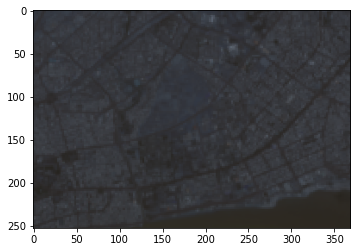

In [4]:
#Build ms image
red_band = rasterio.open('L8_30_RED1.tif').read(1)

green_band = rasterio.open('L8_30_GREEN1.tif').read(1)

blue_band = rasterio.open('L8_30_BLUE1.tif').read(1)

pan_band = rasterio.open('L8_15_pan.tif').read(1)

# MS_image = np.dstack((red_band, green_band, blue_band))

MS_image = cv2.merge([blue_band, green_band, red_band])

plt.imshow(MS_image)
plt.show()

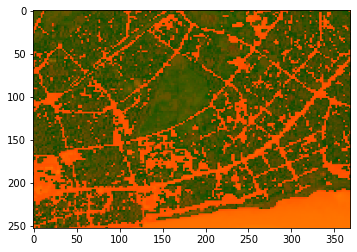

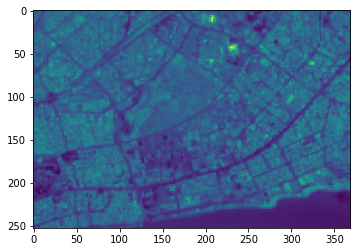

In [14]:
#RGB to HSI
def RGB_TO_HSI(img):

    with np.errstate(divide='ignore', invalid='ignore'):

        #Load image with 32 bit floats as variable type
        bgr = np.float32(img)/255

        #Separate color channels
        blue = bgr[:,:,0]
        green = bgr[:,:,1]
        red = bgr[:,:,2]

        #Calculate Intensity
        def calc_intensity(red, blue, green):
            return np.divide(blue + green + red, 3)

        #Calculate Saturation
        def calc_saturation(red, blue, green):
            minimum = np.minimum(np.minimum(red, green), blue)
            saturation = 1 - (3 / (red + green + blue + 0.001) * minimum)

            return saturation

        #Calculate Hue
        def calc_hue(red, blue, green):
            hue = np.copy(red)

            for i in range(0, blue.shape[0]):
                for j in range(0, blue.shape[1]):
                    hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) / \
                                math.sqrt((red[i][j] - green[i][j])**2 +
                                        ((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j])))
                    hue[i][j] = math.acos(hue[i][j])

                    if blue[i][j] <= green[i][j]:
                        hue[i][j] = hue[i][j]
                    else:
                        hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]

            return hue

        #Merge channels into picture and return image
        hsi = cv2.merge((calc_hue(red, blue, green), calc_saturation(red, blue, green), calc_intensity(red, blue, green)))
        return hsi, calc_intensity(red, blue, green)

hsi_ms, intensity_band = RGB_TO_HSI(MS_image)

plt.imshow(hsi_ms)
plt.show()

plt.imshow(intensity_band)
plt.show()





---


[1]   Apply DWT to MS image and calculate the approximation
and detail coefficients


---



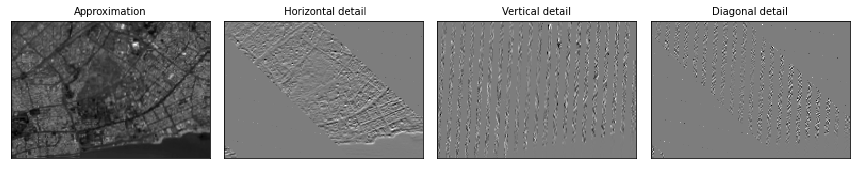

In [ ]:
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(blue_band, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])



fig.tight_layout()
plt.show()




---
[2]   Similarly apply DWT to PAN image and decompose it into
their respective approximation and detail coefficients.


---




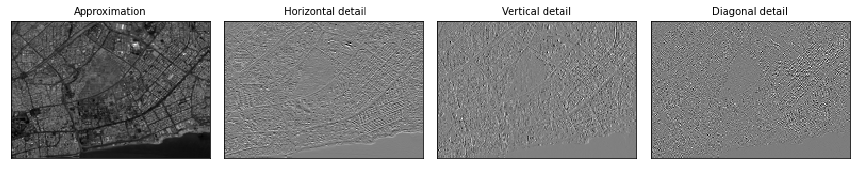

In [ ]:
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs21 = pywt.dwt2(pan_band, 'bior1.3')
LL1, (LH1, HL1, HH1) = coeffs21
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])



fig.tight_layout()

plt.show()



---
[3]   Approximation coefficient of PAN image is replaced with
that of MS image


---




In [ ]:
pan_coe = list(coeffs21)
ms_coe = list(coeffs2)
pan_coe[0] = ms_coe[0]



---
[4]  **Each pair of the detail coefficients obtained in step (1) & (2)
are fused by using the proposed fusion rule based on spatial
frequency given in steps (5)–(9).**


---






---

[5]  PAN Detail Coefficients (PDC) is histogram matched with the
intensity component of the MS Detail Coefficients (MDC).


---



In [ ]:
#Horizontal detail
image = pan_coe[1][0]
reference = ms_coe[1][0]

matched_pan_H = match_histograms(image, reference,multichannel=False,)

np.concatenate(matched_pan_H).astype(None)

len_num = len(matched_pan_H)
i = 0
while i < len_num:
  pan_coe[1][0][i] = matched_pan_H[i]
  i += 1

In [ ]:
#Vertical detail
image = pan_coe[1][1]
reference = ms_coe[1][1]

matched_pan_V = match_histograms(image, reference)
np.concatenate(matched_pan_V).astype(None)

len_num = len(matched_pan_V)
i = 0
while i < len_num:
  pan_coe[1][1][i] = matched_pan_V[i]
  i += 1

In [ ]:
#Diagonal detail
image = pan_coe[1][2]
reference = ms_coe[1][2]

matched_pan_D = match_histograms(image, reference)
np.concatenate(matched_pan_D).astype(None)

len_num = len(matched_pan_D)
i = 0
while i < len_num:
  pan_coe[1][2][i] = matched_pan_D[i]
  i += 1

print(pan_coe[1][0][0][0])

-2.246788e-08


In [ ]:
from os import X_OK
#get the number of rows
M = len(pan_coe[1][0])  #129
#get the number of columns
N = len(pan_coe[1][0][0]) #187

x = 0
y = 1
sf_pan = 0
while x < M:
  while y < N:
    sf_pan1 = (pan_coe[1][0][x][y] - pan_coe[1][0][x][y-1])**2
    sf_pan += sf_pan1
    y += 1

  x += 1

print(sf_pan)





0.007682520410917818
